# Diamond Analysis 

The first part of this project includes an exploratory analysis of ~17,000 loose diamonds collected by webscraping  (see repository for webscraping code) from leading online loose diamond retailers.  The emphasis of the analysis is on extracting key insights to lead an average consumer to the best value and quality diamond based on their preferences.  The second part of the project implements machine learning methods in an attempt to generate a regression model capable of predicting loose diamond prices given several key diamond properties.

Let's start with some background information on the 4 Cs:

## Color
The color of a diamond refers to the tone and saturation of color, or the depth of color in a diamond. The color of a diamond can range from colorless to a yellow or a faint brownish colored hue. Colorless diamonds are rarer and more valuable because they appear whiter and brighter.


<img src="diamond_colors.png">

## Clarity
Clarity describes the presence or absence of inclusions within the diamond and blemishes on its surface.  The fewer inclusions a diamond has, the rarer and more valuable it is.  It is important to note that value can be found here as many diamonds in the VVS and VS range have inclusions which cannot be seen by the naked eye, but whose presence reduce the cost of the diamond.  

<img src="diamond-clarity-scale.png">

## Carat
A carat is a unit of mass.  1 carat = 200 milligrams.

## Cut
Cut is considered by many to be the most important "C." A poorly cut diamond, no matter how great its color and clarity is, will not compare in sparkle and flicker to a better cut diamond with comparatively lower color and clarity.  

<img src="cut copy.png">

GIA (the internationally recognized diamond certifying body) certified diamonds can have cuts classified as either Excellent, Very Good, Good, Fair, or Poor.  The diamonds analyzed here all have a GIA clarity of Excellent.


Finally, we will make some assumptions to constrain the analysis:
1. Diamond carat will fall between 0.75 and 1.25
2. Only excellent cut diamonds will be analyzed as this is typically referred to as the most important diamond property
3. Preference will be given to diamonds in the colorless range


In [19]:
# Start by importing necessary libraries and cleaning the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV, ElasticNet
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
import itertools
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
plt.rcParams['figure.figsize'] = [10, 8]
diamonds = pd.read_csv('diamonds_USD_all_c_12_20.csv')

# Define array of cut/color/clarity using dataframe unique values
dcolors = diamonds['color'].unique()
dclarity = diamonds['clarity'].unique()
dcut = diamonds['cut'].unique()

# Drop all rows that have a price of 0
diamonds = diamonds[~(diamonds == 0).any(axis=1)]

In [20]:
# Lets start by taking a look at the dataset
diamonds.describe(include='all')

,Unnamed: 0,shape,carat,color,clarity,cut,price
count,16850.000000,16850,16850.000000,16850,16850,16850,16850.000000
unique,NaN,1,NaN,6,7,2,NaN
top,NaN,ROUND,NaN,E,VS2,EXCELLENT,NaN
freq,NaN,16850,NaN,2845,2438,16704,NaN
mean,8644.128309,NaN,1.115761,NaN,NaN,NaN,9054.465156
std,5014.768993,NaN,0.241883,NaN,NaN,NaN,4113.888179
min,1.000000,NaN,0.700000,NaN,NaN,NaN,2030.000000
25%,4282.250000,NaN,0.900000,NaN,NaN,NaN,5762.500000
50%,8609.500000,NaN,1.100000,NaN,NaN,NaN,8800.000000
75%,12959.750000,NaN,1.300000,NaN,NaN,NaN,11710.000000


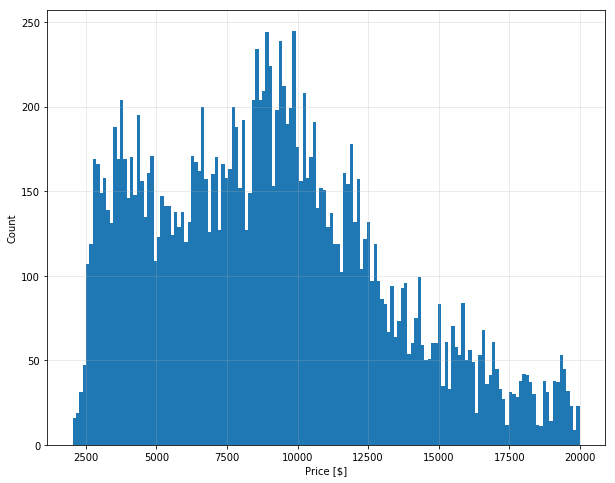

In [21]:
plt.hist(diamonds['price'], bins=150)
plt.ylabel('Count')
plt.xlabel('Price [$]')
plt.grid(alpha=0.3)
plt.show()

From the above table and distribution plot we see we have a total of 16,950 diamonds in our dataset that range in price from \$2,070 to \$21,131.13. The diamonds span 7 categories of clarity, 6 categories of color, 2 categories of cut (for the diamonds scraped for this particular dataset exellent and ideal correspond to subsets of GIA cuts identified as EXCELLENT), and only 1 shape (round).

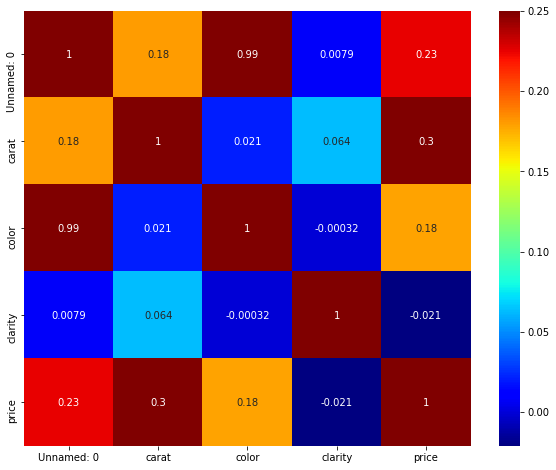

In [26]:
# Here make a heat plot to look at the important variables
diamonds_cmap = diamonds.drop(['cut','shape '],axis=1)
corr_map=diamonds_cmap.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(corr_map, annot=True, vmax=0.25, cmap = 'jet')

Above is a correlation matrix showing the relationships between independent variables.  As price is our target variable, we are interested in seeing the independent variables that are most correlated with price.  We note the misleading picture this correlation matrix can paint; we know that all four c's should be correlated with the price, but clarity does not show a strong trend.  Since all types of clarity exist for diamonds of the same color/carat we need to constrain the properties further to quantify the impact of individual characteristics on price.

Text(0.5,1,'+ = D, o = F, x = E')

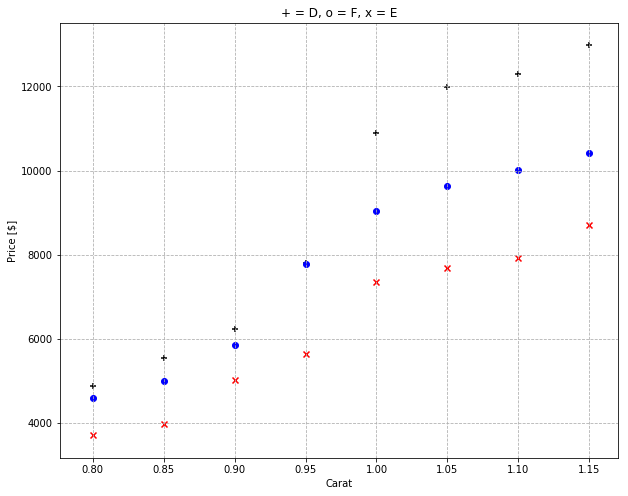

In [39]:
# Define the constrained parameters first
import matplotlib.markers as mlines

pcolor = ['D','F','H']
pclarity = 'VS1'
pcarat = np.arange(0.8,1.2,0.05) # create an array of carats separated by 0.05 carats
crange = 0.025

# Define plot properties
marker = ['+','o','x']
plot_color = ['k','b','r']

# Loop through the colors and carat sizes
I=0
k=[]
fig, ax = plt.subplots()
while I<len(pcolor):
    for w in pcarat:
        dpred = diamonds.loc[(diamonds['clarity']==pclarity) & (diamonds['color']==pcolor[I]) & (diamonds['carat']<w+crange) & (diamonds['carat']>w-crange) & (diamonds['cut']=='EXCELLENT')]
        price_pred = dpred['price'].mean()
        k.append(price_pred)
        plt.scatter(w,price_pred,marker=marker[I],c=plot_color[I])
        plt.grid(linestyle='--')
        plt.ylabel('Price [$]')
        plt.xlabel('Carat')
    I=I+1

#blue_circ = mlines([], [], color='blue', marker='+',
                          #markersize=15, label='D')

#mark1, = plt.plot([],[],marker='o')
#plt.legend(handles=[blue_circ])
    
ka = np.asarray(k, dtype=np.float32)
ka.resize(len(pcolor),len(pcarat))
dk = np.diff(ka)
plt.title('+ = D, o = F, x = E')


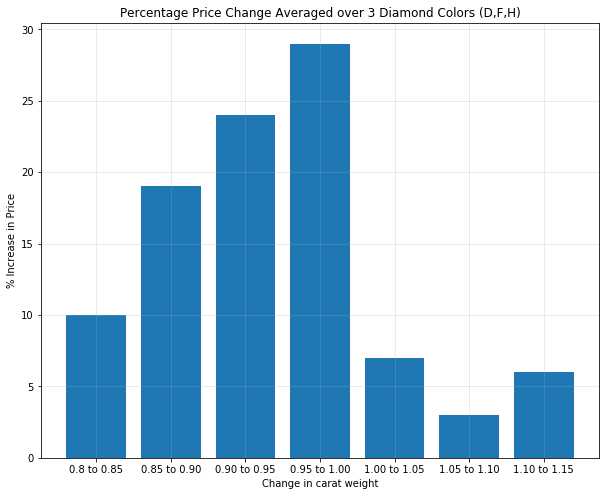

In [28]:
# Calculate the percentage decrease in price from one carat range to the next
pk_decrease=[]
for I in range(0,3):
    pk_decrease.append(np.round((dk[I,:])/ka[I,0:len(pcarat)-1]*100,2))

pk_decrease_mean = np.round(np.mean(pk_decrease,axis=0))

# Generate plot
color_change = ['0.8 to 0.85','0.85 to 0.90','0.90 to 0.95','0.95 to 1.00','1.00 to 1.05','1.05 to 1.10','1.10 to 1.15']
plt.bar(color_change,pk_decrease_mean)
plt.ylabel('% Increase in Price')
plt.xlabel('Change in carat weight')
plt.title('Percentage Price Change Averaged over 3 Diamond Colors (D,F,H)')
plt.grid(alpha=0.3)

Here we have several key takeaways.  From the first plot of price versus carat, a more colorless diamond demands a higher price and the relationship between price and carat size remains similar for each color diamond at a given clarity (here we choose to analyze clarity VS1 but similar trends can be found for all clarities).  Higher carat demands higher price, but a discontinuous jump in price occurs between 0.9 and 1.0 carats. 

Based on the data, a diamond diamond in the 0.9 carat range appears to be the best value.  It has only ~10% smaller volume than a 1 carat diamond, but the 1 carat diamonds are ~40% more expensive for any given diamond color in the VS1 cut range.  The simple explanation for this is that consumers are willing to pay a premium to say they own a diamond that is a full 1 carat.

Next, let's examine the effect of color on diamond price by constraining the carat size to be between 0.875 and 0.925 and have a clarity of VS1.

(4000, 7000)

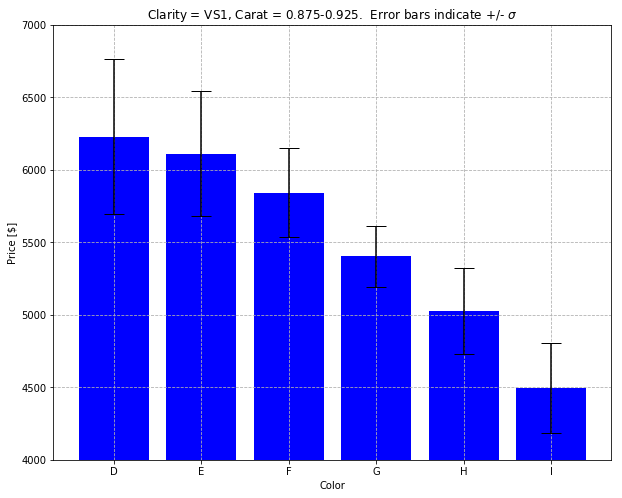

In [14]:
for c in dcolors:
    dpred = diamonds.loc[(diamonds['clarity']=='VS1') & (diamonds['color']==c) & (diamonds['carat']<0.9+crange) & (diamonds['carat']>0.9-crange) & (diamonds['cut']=='EXCELLENT')]
    price_pred = dpred['price'].mean()
    std= dpred['price'].std()
    plt.bar(c,price_pred,color='b', yerr = std, capsize=10)
    
plt.grid(linestyle='--')
plt.ylabel('Price [$]')
plt.xlabel('Color')
plt.title('Clarity = VS1, Carat = 0.875-0.925.  Error bars indicate +/- $\sigma$')
plt.ylim((4000,7000))

As anticipated, price decreases with as the diamond becomes less colorless.  We note that the F diamond color offers a significant savings (>10%) over a D diamond while still remaining within the "colorless" catagory.  While an H color diamond offers even more savings, that is closer to having a distinct yellow color and as such F color will be chosen as the winner in this category. 

Next, we will constrain the color to F and compare the costs of different clarities. 

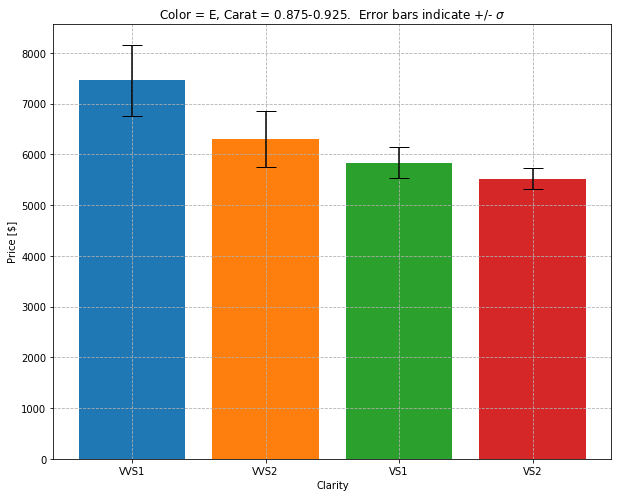

In [15]:
pcolor = 'F'
pclarity = ['VVS1','VVS2','VS1','VS2','S1']
pcarat = 0.9
crange = 0.02

k=0
r=[]
for l in pclarity:
    dpred = diamonds.loc[(diamonds['clarity']==l) & (diamonds['color']==pcolor) & (diamonds['carat']<pcarat+crange) & (diamonds['carat']>pcarat-crange)]
    price_pred = dpred['price'].mean()
    std_clarity = dpred['price'].std()
    r.append(price_pred)
    plt.bar(l,price_pred,yerr=std_clarity, capsize=10)
    
#plt.hist(dpred['price'],bins=15)
plt.xlabel('Clarity')
plt.ylabel('Price [$]')
plt.title('Color = E, Carat = 0.875-0.925.  Error bars indicate +/- $\sigma$')
plt.grid(linestyle='--')


Here we see that a VS1 or VS2 clarity offers a significant value over a VVS1 or VVS2 diamond.  One consideration when picking amongst these categories is the location of the inclusions; as seen in the introductory material the inclusions can occur anywhere in the diamond.  While a VS1 diamond may have more inclusions that a VVS1 or VVS2 diamond, if the inclusion in the VVS2 diamond is located on the face of the diamond rather than the side the VS1 or VS2 diamond may appear more brilliant to the naked eye.  A VS1 or VS2 diamond appears to be the best choice in this category given that the consumer takes careful note of inclusion location.

Based on the analysis and constraints laid out at the onset of the analysis the diamond properties that seem to maximize value and quality are: 

* Color = F
* Carat = 0.875-0.975
* Clarity = VS1 or VS2
* Cut = Excellent

## Part 2: Predicting Prices 

Can we predict a diamond's price given the color, cut, clarity, and carat of a diamond in the dataset?

In [29]:
# Start by making a new training dataframe
train=diamonds.copy()

# Generate dummy variables for the non-numeric properties
color_dummies = pd.get_dummies(diamonds['color'])
clarity_dummies = pd.get_dummies(diamonds['clarity'])
cut_dummies = pd.get_dummies(diamonds['cut'])

# Generate the training dataframe
train=pd.concat([train,color_dummies,clarity_dummies,cut_dummies],axis=1)
train = train.drop(['Unnamed: 0','shape ','cut','color','clarity'],axis=1)


X = train.drop(['price'],axis=1)
Y=pd.DataFrame(train['price'])

# Use 30% of the dataset to train the regressors and use the rest as the test
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [30]:
# Fit a Random Forest Regression
rf = RandomForestRegressor(n_estimators=1000,random_state=42)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test,y_pred_rf))

# Initialize a variable for the rms error values and then append to it
rmse_values = []
rmse_values.append(rmse_rf)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
# Fit a linear regression
clf_lr = LinearRegression()
clf_lr.fit(X_train , y_train)
y_pred_lr = clf_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test,y_pred_lr))

rmse_values.append(rmse_lr)

In [32]:
# Fitting a lasso regression 
clf_la = Lasso(normalize=True)
clf_la.fit(X_train , y_train)
y_pred_la = clf_la.predict(X_test)
rmse_la = np.sqrt(mean_squared_error(y_test,y_pred_la))

rmse_values.append(rmse_la)

In [33]:
# Fitting a ridge regression with 5 fold cross validation
clf_r = Ridge(normalize=True)
clf_r.fit(X_train , y_train)
y_pred_r = clf_r.predict(X_test)
rmse_r = np.sqrt(mean_squared_error(y_test,y_pred_r))

rmse_values.append(rmse_r)

In [34]:
# K-Nearest Neighbors Regression
clf_knn = KNeighborsRegressor(n_neighbors=7)
clf_knn.fit(X_train , y_train)
y_pred_knn = clf_knn.predict(X_test)
rmse_knn = np.sqrt(mean_squared_error(y_test,y_pred_knn))

rmse_values.append(rmse_knn)

In [35]:
# Fitting a gradient boosting regressor
clf_gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,max_depth=1, random_state=0, loss='ls',verbose = 0)
clf_gb.fit(X_train , y_train)
y_pred_gb = clf_gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test,y_pred_gb))

rmse_values.append(rmse_gb)

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
# Generate a dataframe to show RMS Error of each technique
reg_techniques = ['Random Forest Regressor','Linear Regression','Lasso Regression','Ridge Regression','K-Nearest Neighbors','GradientBoostingRegressor']
compare = pd.DataFrame({'Algorithm' : reg_techniques , 'RMS Error': rmse_values})
compare.sort_values(by=['RMS Error'] ,ascending=True)

,Algorithm,RMS Error
0,Random Forest Regressor,620.073920
4,K-Nearest Neighbors,709.626684
5,GradientBoostingRegressor,1405.158293
1,Linear Regression,1503.355918
2,Lasso Regression,1533.346244
3,Ridge Regression,2405.893839


Text(0.5,1,'Random Forest Regressor Results')

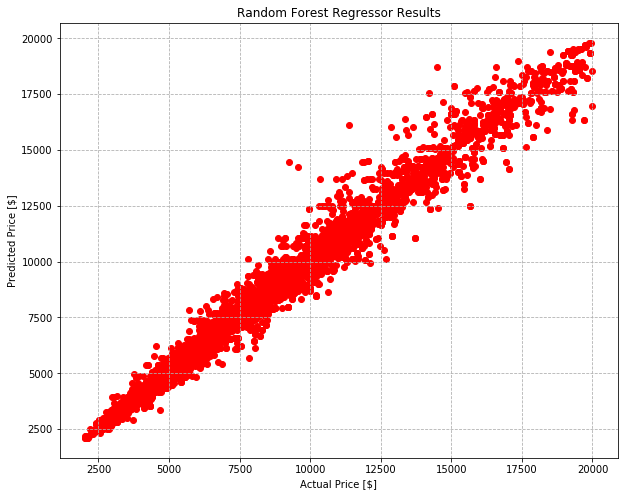

In [37]:
# Print prediction for Random Forest
plt.scatter(y_test,y_pred_rf,color='r')
plt.grid(linestyle='--')
plt.ylabel('Predicted Price [$]')
plt.xlabel('Actual Price [$]')
plt.title('Random Forest Regressor Results')

The Random Forest Regression produces price predictions with the lowest RMS error.  We also note from the plot of predicted price from the Random Forest Regression versus the actual price that much of the scatter in the data appears in the >$12,500 price range where the least amount of data is available to train the model.

Image references:
http://diamondsellersguide.com/tag/diamond-colors/
https://www.onlinediamondbuyingadvice.com/diamond-education/diamond-clarity/
http://shira-diamonds.com/diamond-blog/learn-diamond-cuts/
